# NYC Taxi Graph Mining - Complete Pipeline Runner

Notebook này chạy toàn bộ pipeline và hiển thị kết quả từng bước.

**Pipeline gồm 5 bước:**
1. Build Graph (MapReduce)
2. PageRank Analysis
3. Community Detection (Clustering)
4. Visualization
5. Benchmark & Scalability

**Yêu cầu:**
- Hadoop/Spark cluster đã chạy
- Dữ liệu đã upload lên HDFS
- Python environment đã setup

In [1]:
# Setup và imports
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import subprocess
import time
from datetime import datetime
import json

# Display settings
from IPython.display import display, HTML, Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Setup completed!")
print(f"📁 Project root: {project_root}")

✅ Setup completed!
📁 Project root: /home/tiennd/massive_data_mining


## 🔍 Step 0: Pre-flight Checks

Kiểm tra hệ thống trước khi chạy pipeline.

In [2]:
def run_command(cmd, description="Running command"):
    """Execute shell command and return output"""
    print(f"🚀 {description}...")
    print(f"   Command: {cmd}")
    
    try:
        result = subprocess.run(
            cmd, 
            shell=True, 
            capture_output=True, 
            text=True,
            timeout=30
        )
        
        if result.returncode == 0:
            print("✅ Success!")
            return result.stdout
        else:
            print(f"❌ Failed with code {result.returncode}")
            print(f"   Error: {result.stderr}")
            return None
    except subprocess.TimeoutExpired:
        print("⏱️  Command timed out (30s)")
        return None
    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Check HDFS
print("="*70)
print("CHECKING HDFS")
print("="*70)
run_command("hdfs dfs -ls /", "Checking HDFS root")
run_command("hdfs dfs -ls /user/taxi/raw_data/ | head -5", "Checking data files")

# Check Spark
print("\n" + "="*70)
print("CHECKING SPARK CLUSTER")
print("="*70)
run_command("curl -s http://master:8080 | grep -o '<title>.*</title>' || echo 'Spark Master Web UI'", 
            "Checking Spark Master")

# Check services
print("\n" + "="*70)
print("CHECKING SERVICES")
print("="*70)
run_command("jps", "Checking Java processes on Master")

CHECKING HDFS
🚀 Checking HDFS root...
   Command: hdfs dfs -ls /
✅ Success!
🚀 Checking data files...
   Command: hdfs dfs -ls /user/taxi/raw_data/ | head -5
✅ Success!

CHECKING SPARK CLUSTER
🚀 Checking Spark Master...
   Command: curl -s http://master:8080 | grep -o '<title>.*</title>' || echo 'Spark Master Web UI'
✅ Success!

CHECKING SERVICES
🚀 Checking Java processes on Master...
   Command: jps
✅ Success!


'8928 ResourceManager\n15890 Worker\n8357 DataNode\n8183 NameNode\n9097 NodeManager\n70826 Jps\n8636 SecondaryNameNode\n15581 Master\n'

## 📊 Step 1: Build Graph (MapReduce)

Xây dựng edge list từ 30GB taxi data.

**Expected:**
- Runtime: 1-2 giờ (full data)
- Output: Edge list in HDFS

In [3]:
# Step 1: Build Graph
start_time = time.time()

print("="*70)
print("STEP 1: BUILD GRAPH")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

cmd = f"""
cd {project_root} && \
export PYTHONPATH="{project_root}:$PYTHONPATH" && \
spark-submit \
    --master spark://master:7077 \
    --deploy-mode client \
    --driver-memory 500m \
    --executor-memory 500m \
    --executor-cores 1 \
    --num-executors 2 \
    --archives hdfs://master:9000/user/taxi/python_env/mmds-venv.tar.gz#mmds-venv \
    --conf spark.pyspark.python=./mmds-venv/bin/python3 \
    --conf spark.pyspark.driver.python=python3 \
    --packages graphframes:graphframes:0.8.3-spark3.5-s_2.12 \
    src/1_build_graph.py
"""

# Run the command (this will take a while)
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

elapsed = time.time() - start_time

print(f"\n⏱️  Elapsed time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
print(f"⏰ End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if result.returncode == 0:
    print("✅ Step 1 completed successfully!")
else:
    print(f"❌ Step 1 failed with code {result.returncode}")
    print("Last 50 lines of output:")
    print(result.stdout[-2000:])

STEP 1: BUILD GRAPH
⏰ Start time: 2026-02-05 16:05:25

⏱️  Elapsed time: 99.74 seconds (1.66 minutes)
⏰ End time: 2026-02-05 16:07:04
✅ Step 1 completed successfully!


In [4]:
# Verify output
print("🔍 Verifying edge list output...")
output = run_command("hdfs dfs -ls /user/taxi/graph/edge_list", "Checking edge list")

if output:
    print("✅ Edge list created successfully!")
    # Get file count
    count_output = run_command("hdfs dfs -ls /user/taxi/graph/edge_list | wc -l", "Counting files")
    print(f"   Number of files: {count_output.strip() if count_output else 'unknown'}")

🔍 Verifying edge list output...
🚀 Checking edge list...
   Command: hdfs dfs -ls /user/taxi/graph/edge_list
✅ Success!
✅ Edge list created successfully!
🚀 Counting files...
   Command: hdfs dfs -ls /user/taxi/graph/edge_list | wc -l
✅ Success!
   Number of files: 3


## 🏆 Step 2: PageRank Analysis

Tính PageRank scores cho các taxi zones.

**Expected:**
- Runtime: 30-60 phút
- Output: PageRank scores for 260 zones

In [5]:
# Step 2: PageRank
start_time = time.time()

print("="*70)
print("STEP 2: PAGERANK")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

cmd = f"""
cd {project_root} && \
export PYTHONPATH="{project_root}:$PYTHONPATH" && \
bash run_pagerank.sh
"""

result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

elapsed = time.time() - start_time

print(f"\n⏱️  Elapsed time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
print(f"⏰ End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if result.returncode == 0:
    print("✅ Step 2 completed successfully!")
else:
    print(f"❌ Step 2 failed with code {result.returncode}")
    print("Last 50 lines of output:")
    print(result.stdout[-2000:])

STEP 2: PAGERANK
⏰ Start time: 2026-02-05 16:07:34

⏱️  Elapsed time: 59.00 seconds (0.98 minutes)
⏰ End time: 2026-02-05 16:08:33
✅ Step 2 completed successfully!


📊 Loading PageRank results...


26/02/05 16:09:50 WARN Utils: Your hostname, tiennd-VMUbuntu resolves to a loopback address: 127.0.1.1; using 192.168.202.129 instead (on interface ens33)
26/02/05 16:09:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/05 16:09:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Loaded 261 zones

🏆 TOP 20 ZONES BY PAGERANK:


,zone_id,pagerank
11,14,1.284494
112,181,1.252614
68,231,1.248559
9,170,1.235857
234,61,1.226729
78,161,1.214020
16,140,1.204864
240,48,1.202781
198,230,1.201008
168,25,1.198241


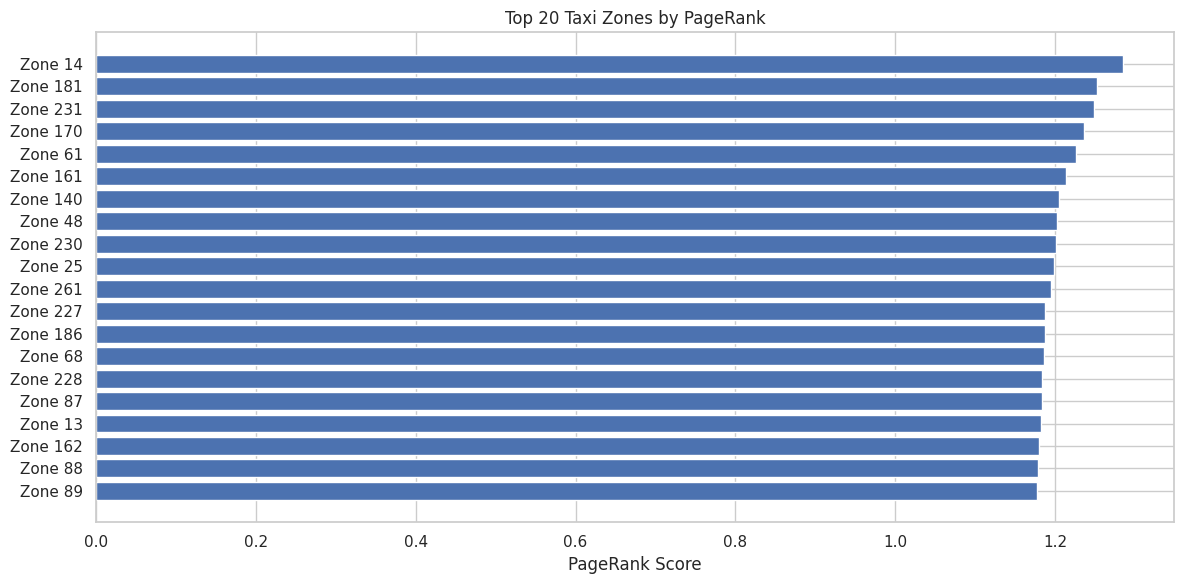

In [6]:
# Load and display PageRank results
from pyspark.sql import SparkSession

print("📊 Loading PageRank results...")

spark = SparkSession.builder \
    .appName("Notebook_Analytics") \
    .master("local[*]") \
    .getOrCreate()

try:
    # Read PageRank scores
    pr_df = spark.read.parquet("hdfs://master:9000/user/taxi/results/pagerank_scores")
    pr_pdf = pr_df.toPandas().sort_values('pagerank', ascending=False)
    
    print(f"✅ Loaded {len(pr_pdf)} zones")
    
    # Display top 20
    print("\n🏆 TOP 20 ZONES BY PAGERANK:")
    display(pr_pdf.head(20))
    
    # Simple visualization
    plt.figure(figsize=(12, 6))
    plt.barh(range(20), pr_pdf.head(20)['pagerank'].values)
    plt.yticks(range(20), [f"Zone {int(z)}" for z in pr_pdf.head(20)['zone_id'].values])
    plt.xlabel('PageRank Score')
    plt.title('Top 20 Taxi Zones by PageRank')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error loading results: {str(e)}")
finally:
    spark.stop()

## 🎯 Step 3: Community Detection

Phát hiện communities trong đồ thị bằng Label Propagation.

**Expected:**
- Runtime: 20-40 phút
- Output: 25-35 communities

In [7]:
# Step 3: Clustering
start_time = time.time()

print("="*70)
print("STEP 3: CLUSTERING")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

cmd = f"""
cd {project_root} && \
export PYTHONPATH="{project_root}:$PYTHONPATH" && \
bash run_clustering.sh
"""

result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

elapsed = time.time() - start_time

print(f"\n⏱️  Elapsed time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")
print(f"⏰ End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if result.returncode == 0:
    print("✅ Step 3 completed successfully!")
else:
    print(f"❌ Step 3 failed with code {result.returncode}")

STEP 3: CLUSTERING
⏰ Start time: 2026-02-05 16:10:50

⏱️  Elapsed time: 55.65 seconds (0.93 minutes)
⏰ End time: 2026-02-05 16:11:46
✅ Step 3 completed successfully!


📊 Loading community results...
✅ Found 1 communities

🔝 TOP 10 COMMUNITIES BY SIZE:


,community_id,num_zones,total_pagerank,avg_pagerank
0,137,261,261.0,1.0


❌ Error: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (1).


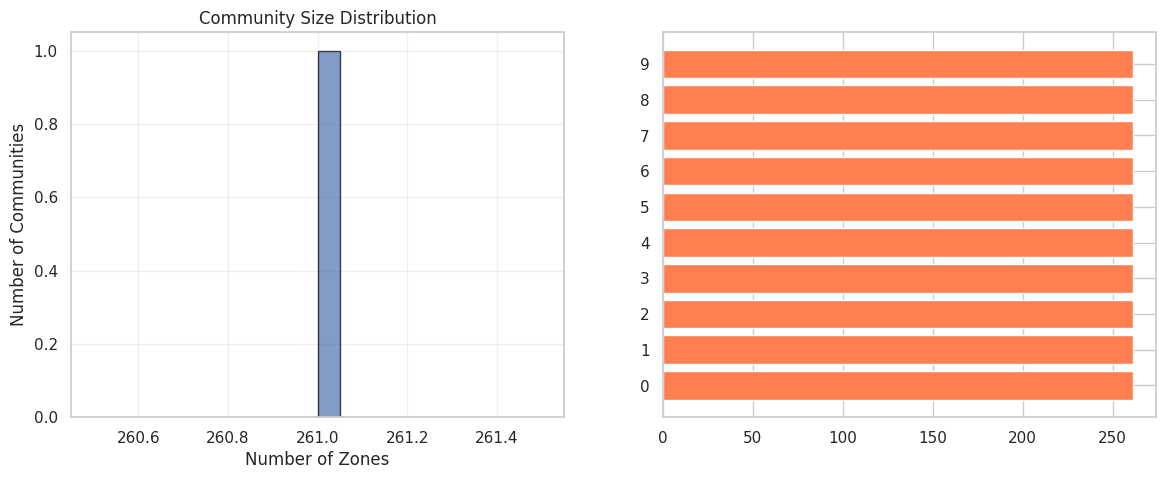

In [8]:
# Load and analyze communities
from pyspark.sql import SparkSession

print("📊 Loading community results...")

spark = SparkSession.builder \
    .appName("Notebook_Analytics") \
    .master("local[*]") \
    .getOrCreate()

try:
    # Read community stats
    comm_stats = spark.read.parquet("hdfs://master:9000/user/taxi/results/clustering/community_statistics")
    comm_pdf = comm_stats.toPandas().sort_values('num_zones', ascending=False)
    
    print(f"✅ Found {len(comm_pdf)} communities")
    
    # Display top 10
    print("\n🔝 TOP 10 COMMUNITIES BY SIZE:")
    display(comm_pdf.head(10))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Community size distribution
    ax1.hist(comm_pdf['num_zones'], bins=20, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Number of Zones')
    ax1.set_ylabel('Number of Communities')
    ax1.set_title('Community Size Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Top 10 communities
    top10 = comm_pdf.head(10)
    ax2.barh(range(10), top10['num_zones'].values, color='coral')
    ax2.set_yticks(range(10))
    ax2.set_yticklabels([f"Comm {int(c)}" for c in top10['community_id'].values])
    ax2.invert_yaxis()
    ax2.set_xlabel('Number of Zones')
    ax2.set_title('Top 10 Largest Communities')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ Error: {str(e)}")
finally:
    spark.stop()

## 📈 Step 4: Visualization

Tạo visualizations và summary reports.

**Expected:**
- Runtime: 5-10 phút
- Output: PNG charts + CSV summaries

In [9]:
# Step 4: Visualization
start_time = time.time()

print("="*70)
print("STEP 4: VISUALIZATION")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

cmd = f"""
cd {project_root} && \
export PYTHONPATH="{project_root}:$PYTHONPATH" && \
bash run_visualization.sh
"""

result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

elapsed = time.time() - start_time

print(f"\n⏱️  Elapsed time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

if result.returncode == 0:
    print("✅ Step 4 completed successfully!")
else:
    print(f"❌ Step 4 failed with code {result.returncode}")

STEP 4: VISUALIZATION
⏰ Start time: 2026-02-05 16:12:59

⏱️  Elapsed time: 11.15 seconds (0.19 minutes)
✅ Step 4 completed successfully!


🖼️  Generated visualizations:

📊 Charts: 2
   - community_analysis.png
   - pagerank_distribution.png

📄 Reports: 2
   - summary_statistics.csv
   - top50_zones_detailed.csv

📊 community_analysis.png


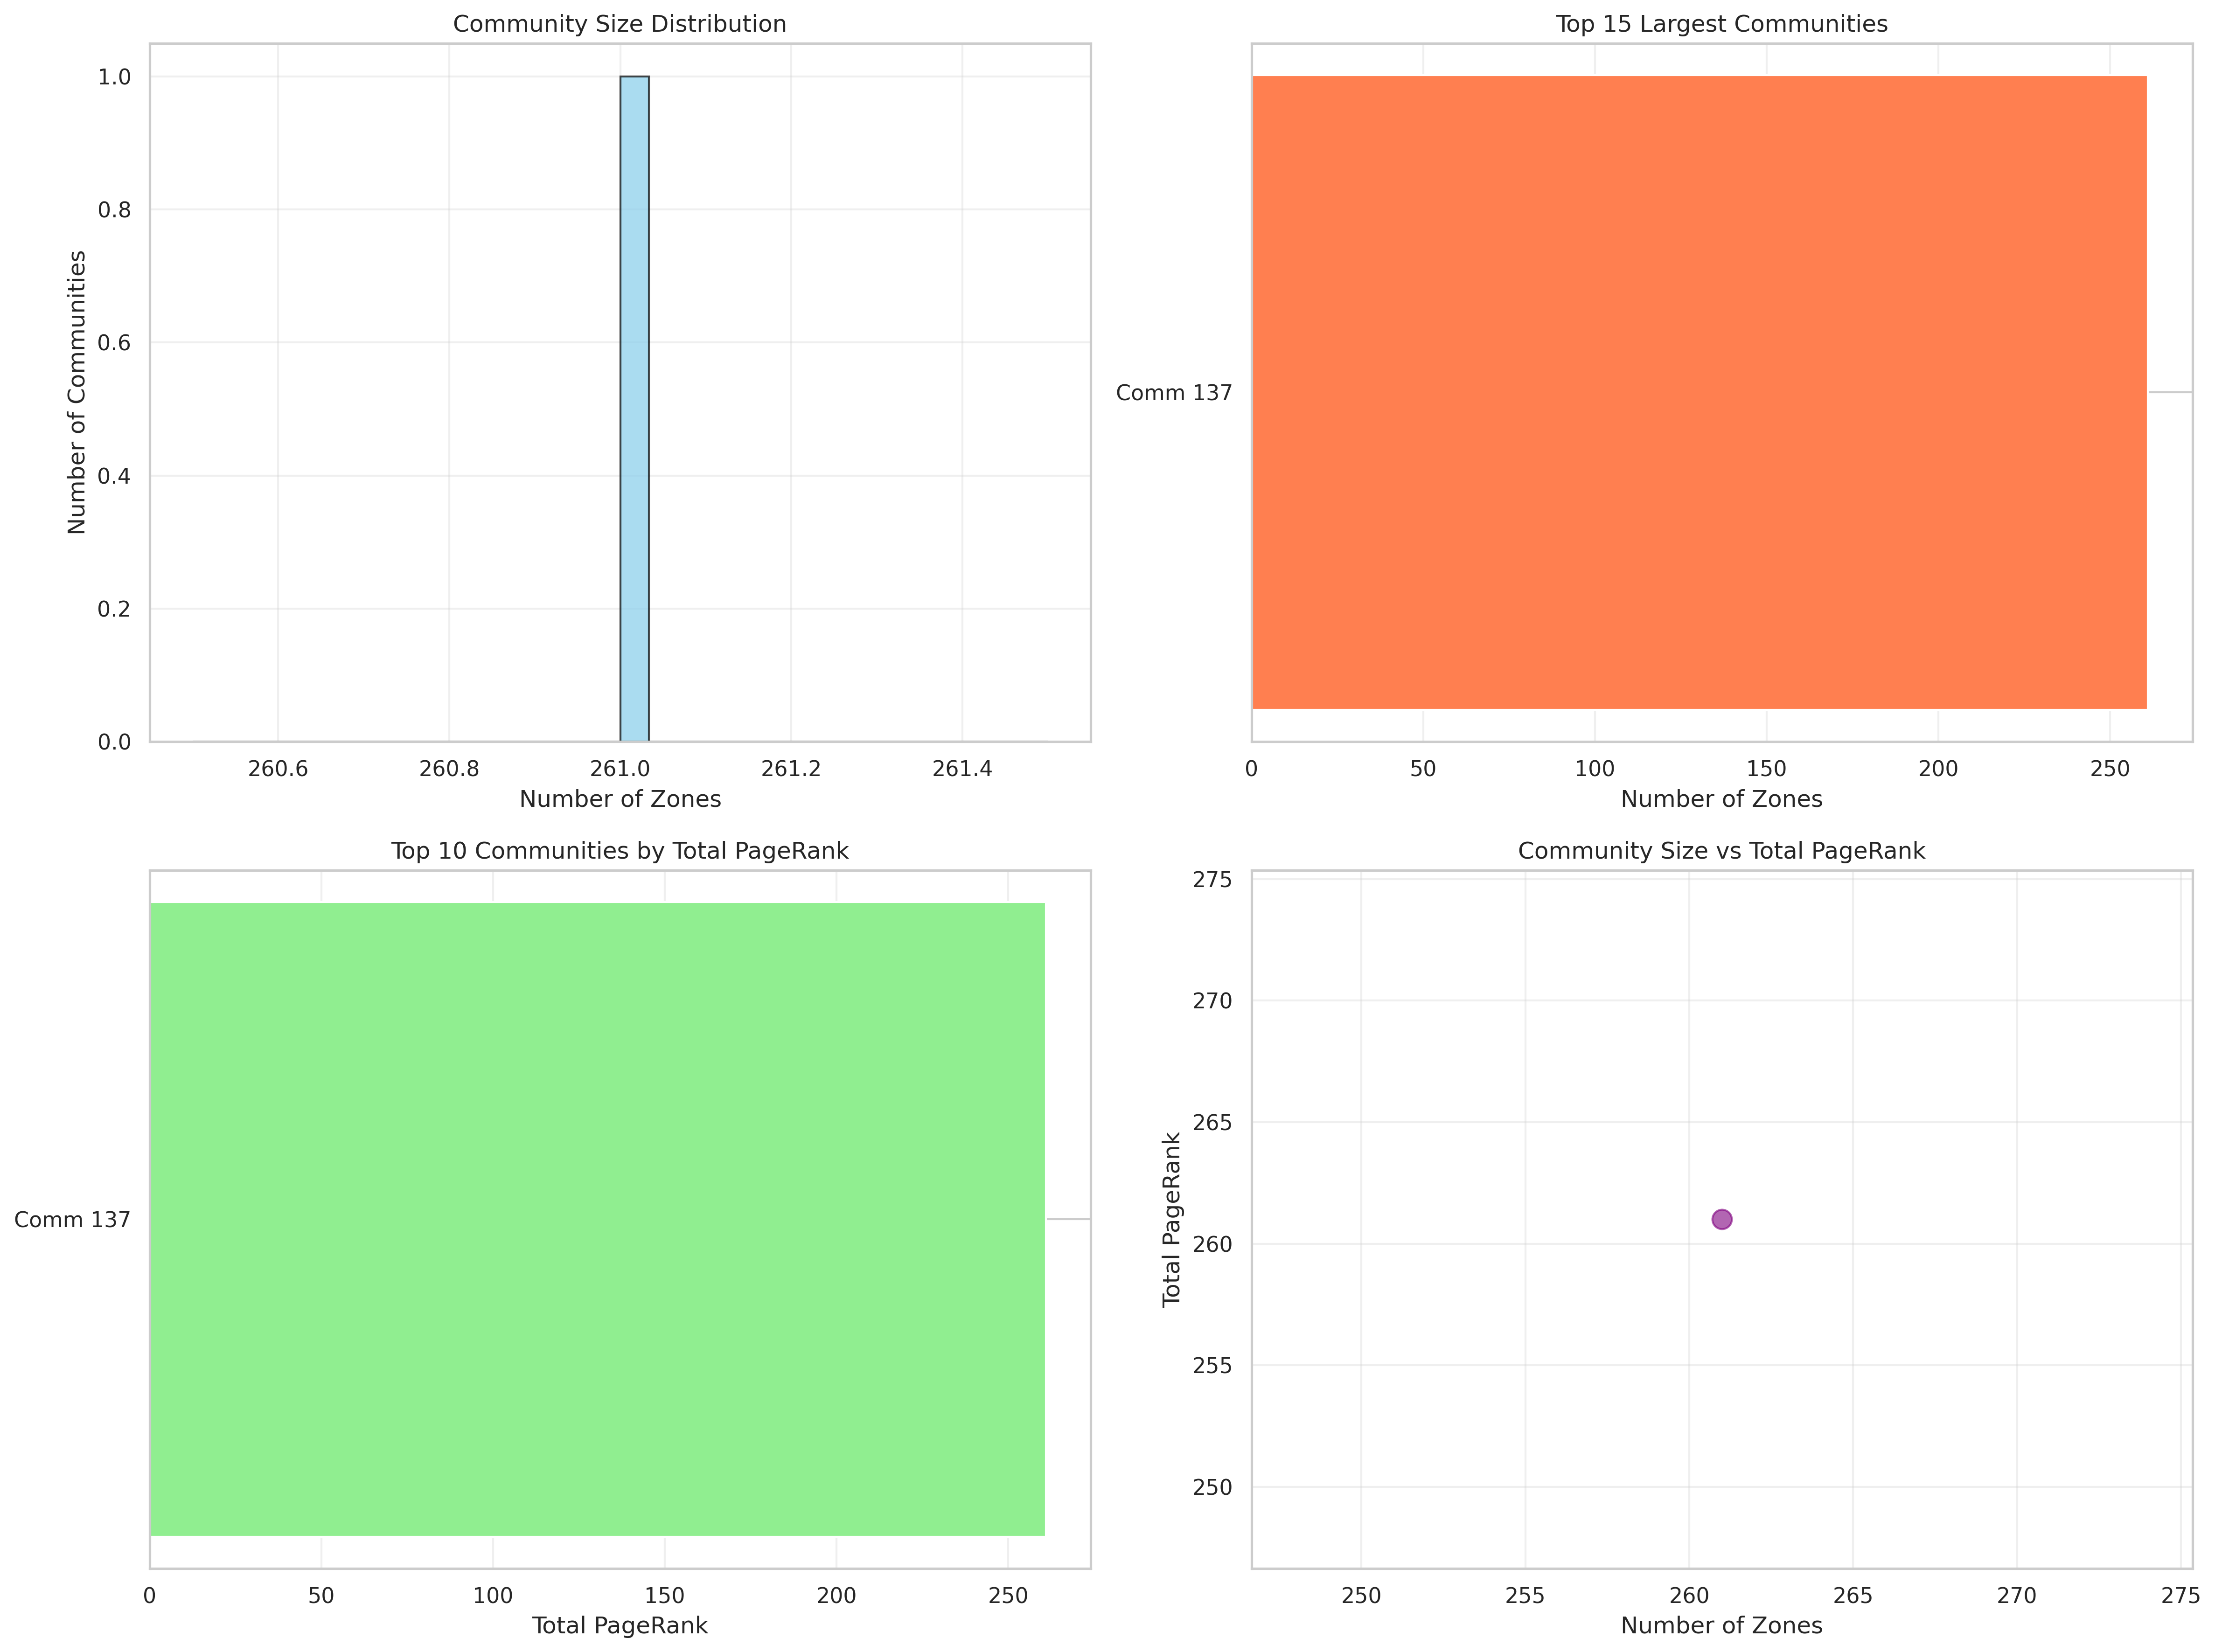


📊 pagerank_distribution.png


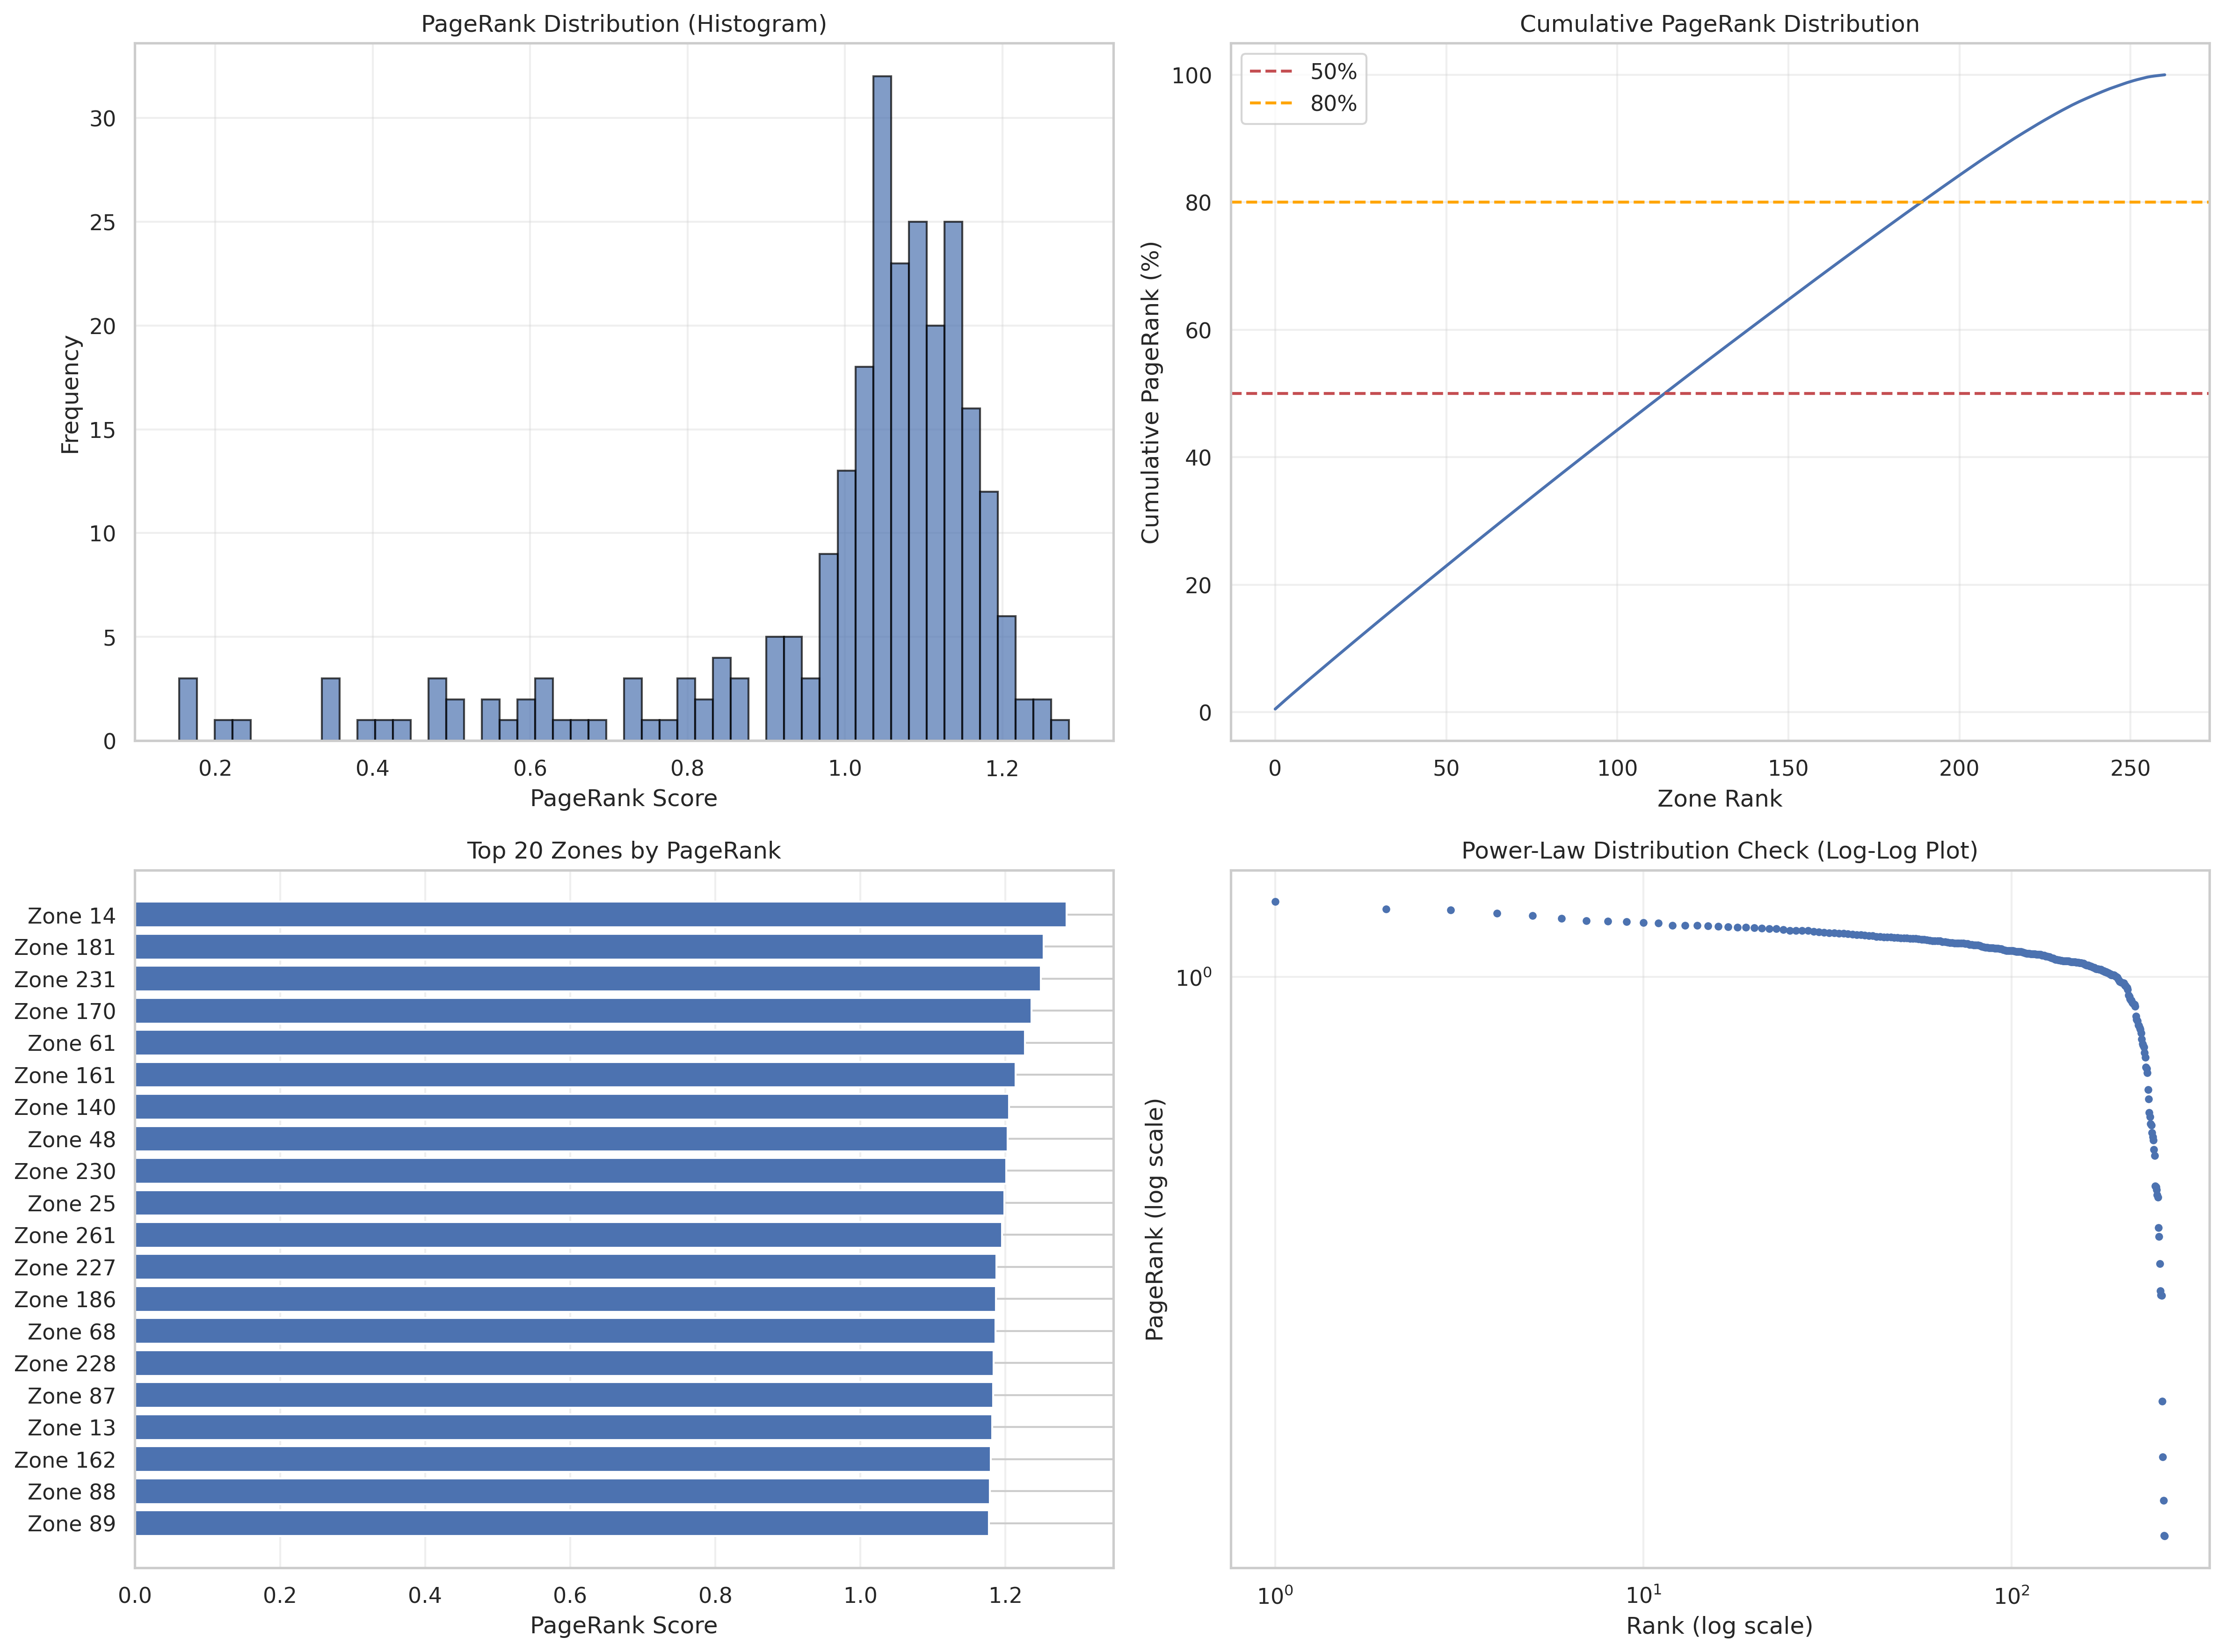

In [12]:
# Display generated visualizations
results_dir = project_root / "results" / "visualizations"

print("🖼️  Generated visualizations:")

# List all PNG files
png_files = list(results_dir.glob("*.png"))
csv_files = list(results_dir.glob("*.csv"))

print(f"\n📊 Charts: {len(png_files)}")
for f in png_files:
    print(f"   - {f.name}")

print(f"\n📄 Reports: {len(csv_files)}")
for f in csv_files:
    print(f"   - {f.name}")

# Display images
for png_file in png_files:
    print(f"\n{'='*70}")
    print(f"📊 {png_file.name}")
    print('='*70)
    display(Image(filename=str(png_file)))

In [13]:
# Display summary statistics
summary_file = results_dir / "summary_statistics.csv"

if summary_file.exists():
    print("📊 SUMMARY STATISTICS:")
    print("="*70)
    summary_df = pd.read_csv(summary_file, index_col=0)
    display(summary_df)
else:
    print("⚠️  Summary file not found")

# Display top zones
top_zones_file = results_dir / "top50_zones_detailed.csv"

if top_zones_file.exists():
    print("\n🏆 TOP 50 ZONES:")
    print("="*70)
    top_zones_df = pd.read_csv(top_zones_file)
    display(top_zones_df.head(20))
else:
    print("⚠️  Top zones file not found")

📊 SUMMARY STATISTICS:


,Value
Total Zones,261.000000
Total Communities,1.000000
Avg PageRank,1.000000
Max PageRank,1.284494
Min PageRank,0.154372
Avg Community Size,261.000000
Largest Community,261.000000
Smallest Community,261.000000



🏆 TOP 50 ZONES:


,zone_id,pagerank
0,14,1.284494
1,181,1.252614
2,231,1.248559
3,170,1.235857
4,61,1.226729
5,161,1.214020
6,140,1.204864
7,48,1.202781
8,230,1.201008
9,25,1.198241


## ⚡ Step 5: Benchmark & Scalability

Đo performance và chứng minh tính massive.

**Expected:**
- Runtime: 30-60 phút
- Output: Benchmark metrics

In [17]:
# Step 5: Benchmark (optional - comment out if want to skip)
start_time = time.time()

print("="*70)
print("STEP 5: BENCHMARK")
print("="*70)
print(f"⏰ Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

cmd = f"""
cd {project_root} && \
export PYTHONPATH="{project_root}:$PYTHONPATH" && \
bash run_benchmark.sh
"""

result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

elapsed = time.time() - start_time

print(f"\n⏱️  Elapsed time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

if result.returncode == 0:
    print("✅ Step 5 completed successfully!")
else:
    print(f"❌ Step 5 failed with code {result.returncode}")

STEP 5: BENCHMARK
⏰ Start time: 2026-02-05 16:29:51

⏱️  Elapsed time: 66.67 seconds (1.11 minutes)
✅ Step 5 completed successfully!


📊 Found 1 benchmark result(s)

📄 Loading: benchmark_20260205_154450.json


,run_name,step,sample_fraction,raw_rows,cleaned_rows,edges,runtime_seconds,runtime_minutes,timestamp,vertices,iterations,pagerank_runtime_seconds,total_runtime_seconds,total_runtime_minutes
0,1% Sample,build_graph,0.01,443614.0,394040.0,19242,42.863094,0.714385,2026-02-05T15:44:36.513517,NaN,NaN,NaN,NaN,NaN
1,5% Sample,build_graph,0.05,2220922.0,1972282.0,32930,2.832350,0.047206,2026-02-05T15:44:39.345927,NaN,NaN,NaN,NaN,NaN
2,PageRank 1%,pagerank,0.01,NaN,NaN,19175,NaN,NaN,2026-02-05T15:44:50.993277,256.0,5.0,7.833385,11.189095,0.186485


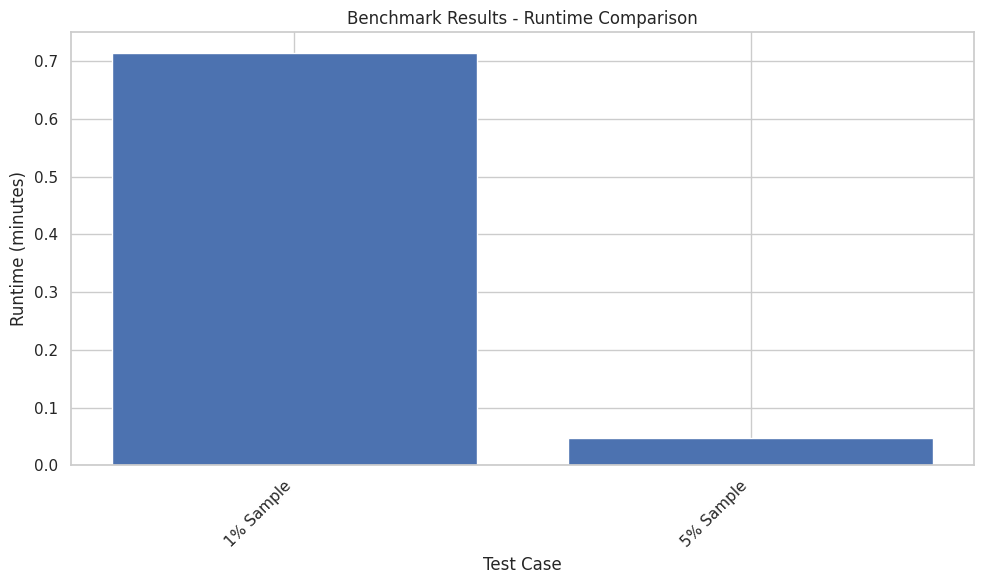

In [20]:
# Display benchmark results
benchmark_dir = project_root / "results" / "benchmarks"

if benchmark_dir.exists():
    json_files = list(benchmark_dir.glob("*.json"))
    
    if json_files:
        print(f"📊 Found {len(json_files)} benchmark result(s)")
        
        # Load latest benchmark
        latest = max(json_files, key=lambda p: p.stat().st_mtime)
        print(f"\n📄 Loading: {latest.name}")
        
        with open(latest, 'r') as f:
            benchmark_data = json.load(f)
        
        # Display as DataFrame
        benchmark_df = pd.DataFrame(benchmark_data)
        display(benchmark_df)
        
        # Visualize runtimes
        if 'runtime_minutes' in benchmark_df.columns:
            plt.figure(figsize=(10, 6))
            plt.bar(benchmark_df['run_name'], benchmark_df['runtime_minutes'])
            plt.xlabel('Test Case')
            plt.ylabel('Runtime (minutes)')
            plt.title('Benchmark Results - Runtime Comparison')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("⚠️  No benchmark files found")
else:
    print("⚠️  Benchmark directory not found")

## 🎉 Pipeline Summary

Tổng kết toàn bộ pipeline.

In [18]:
# Final summary
print("="*70)
print("🎉 PIPELINE COMPLETED!")
print("="*70)

print("\n📊 Results Location:")
print(f"   - HDFS: hdfs://master:9000/user/taxi/results/")
print(f"   - Local: {project_root}/results/")

print("\n📁 Generated Files:")
print("   ✅ Edge list (HDFS)")
print("   ✅ PageRank scores (HDFS)")
print("   ✅ Community assignments (HDFS)")
print("   ✅ Visualizations (Local)")
print("   ✅ Summary reports (Local)")
print("   ✅ Benchmark results (Local)")

print("\n📌 Next Steps:")
print("   1. Xem visualizations trong results/visualizations/")
print("   2. Đọc summary reports (CSV files)")
print("   3. Viết báo cáo theo PRESENTATION_GUIDE.md")
print("   4. Chuẩn bị demo và slides")

print("\n" + "="*70)
print("✅ ALL DONE!")
print("="*70)

🎉 PIPELINE COMPLETED!

📊 Results Location:
   - HDFS: hdfs://master:9000/user/taxi/results/
   - Local: /home/tiennd/massive_data_mining/results/

📁 Generated Files:
   ✅ Edge list (HDFS)
   ✅ PageRank scores (HDFS)
   ✅ Community assignments (HDFS)
   ✅ Visualizations (Local)
   ✅ Summary reports (Local)
   ✅ Benchmark results (Local)

📌 Next Steps:
   1. Xem visualizations trong results/visualizations/
   2. Đọc summary reports (CSV files)
   3. Viết báo cáo theo PRESENTATION_GUIDE.md
   4. Chuẩn bị demo và slides

✅ ALL DONE!
